# Online data processing

This notebook shows a simple FFT example to illustrate online data processing

In [1]:
import os
import gevent
from bliss.data.scan import ScansWatcher, ScansObserver

/users/denolf/virtualenvs/bliss_jup/ubuntu_20_04/lib/python3.7/site-packages/tango/utils.py:181: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  CmdArgType.DevString: numpy.str,


## Plot helper

Updateable matplotlib graphs

In [2]:
import matplotlib.pyplot as plt
from IPython import display

class Plotter:
    def __init__(self, max_plots=5):
        self.plots = list()
        self.fig = None
        self.max_plots = max_plots

    def update_plot_data(self, plot, label, x, y):
        if self.fig is None:
            self.fig, self.ax = plt.subplots(figsize=(10,6))
            self.ax.set_xlabel("Hz")
            self.ax.set_ylabel("Amplitude")
            self.hdisplay = display.display("", display_id=True)

        if plot is None:
            label = label.split(":")[-1]
            while label.startswith("_"):
                label = label[1:]
            plot = self.ax.plot(x, y, label=label)[0]
            self.plots.append(plot)
        else:
            plot.set_xdata(x)
            plot.set_ydata(y)

        self.update_display()
        return plot

    def update_display(self):
        if self.fig is None:
            return
        self.ax.relim()
        self.ax.autoscale()
        self.ax.legend()
        self.hdisplay.update(self.fig)

    def purge_plots(self):
        while len(self.plots) > self.max_plots:
            plot = self.plots.pop(0)
            plot.remove()
        self.update_display()

/users/denolf/virtualenvs/bliss_jup/ubuntu_20_04/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Scan data watcher

A loop that runs forever and received all scan data related to a specific BLISS session

In [3]:
def watch_scans(session_name):
    watcher = ScansWatcher(session_name)
    watcher.set_observer(ScanObserver(max_plots=5))

    print("Start data processing ...", flush=True)
    try:
        watcher.run()
    except KeyboardInterrupt:
        pass
    print("Data processing stopped", flush=True)

/users/denolf/virtualenvs/bliss_jup/ubuntu_20_04/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Data processing

Calculate FFT when new data arrives and update the plot. Maximally shows 5 plots by default.

In [4]:
import numpy
from scipy.fft import fft, fftfreq
from scipy.signal import blackman
from scipy.interpolate import interp1d

def calc_fft(x, y):
    N = min(len(x), len(y))
    if N <= 3:
        return None, None
    x = x[:N]
    y = y[:N]

    T = x[-1]/(N-1)
    xnew = numpy.linspace(0, x[-1], N)
    y = interp1d(x, y, fill_value="extrapolate")(xnew)

    xf = fftfreq(N, T)[:N//2]
    yf = fft(y*blackman(N))
    yf = 2.0/N * numpy.abs(yf[0:N//2])

    return xf, yf

class ScanObserver(ScansObserver):
    def __init__(self, *args, max_plots=5, **kw):
        super().__init__(*args, **kw)
        self.scan_data = dict()
        self.plotter = Plotter(max_plots=max_plots)

    def on_scan_started(self, scan_db_name, scan_info):
        self.scan_data[scan_db_name] = {"x": [], "y": [], "plot": None}

    def on_scan_finished(self, scan_db_name, scan_info):
        self.scan_data.pop(scan_db_name)
        self.plotter.purge_plots()

    def on_scalar_data_received(
        self, scan_db_name, channel_name, index, data_bunch
    ):
        if channel_name.endswith("diode1"):
            self.append_data(scan_db_name, "y", data_bunch)
        elif channel_name.endswith("elapsed_time"):
            self.append_data(scan_db_name, "x", data_bunch)

    def append_data(self, scan_db_name, key, values):
        info = self.scan_data[scan_db_name]
        info[key] = numpy.append(info[key], values)
        self.update_fft(scan_db_name)

    def update_fft(self, scan_db_name):
        info = self.scan_data[scan_db_name]
        xf, yf = calc_fft(info["x"], info["y"])
        if xf is not None:
            info["plot"] = self.plotter.update_plot_data(
                info["plot"], scan_db_name, xf, yf
            )

## Connect and receive Redis data

Run this command in the shell:
 s=loopscan(200,0.03,diode1)

Start data processing ...


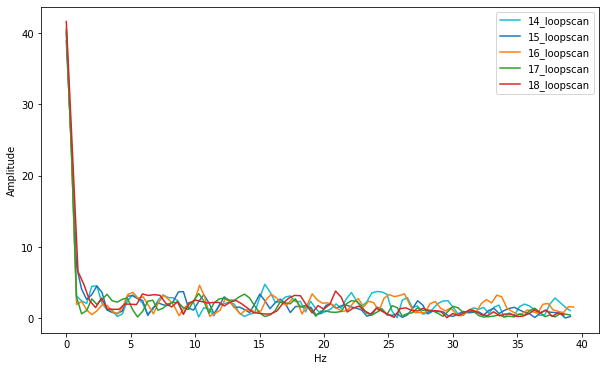

In [ ]:
os.environ["BEACON_HOST"] = "localhost:10001"

print("Run this command in the shell:")
print(" s=loopscan(200,0.03,diode1)")
print("")

watch_scans("demo_session")